In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as sts
import numpy as np
import seaborn as sns
import pickle
from sklearn import preprocessing
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
%matplotlib inline

In [2]:
def plot_confusion_matrix(matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

In [3]:
data_file = """./data/DB_embedding.txt"""

In [4]:
with open(data_file, mode="r") as fp:
    svmformat_list = fp.read().splitlines()

# For each line we save the key:values to a dict
pandas_label_list = []
pandas_feature_list = []
for line in svmformat_list:
    feature_dict = {}

    items = line.split()
    pandas_label_list.append({'label': items[0]})

    for pair in items[1:]:
        feature_name, count = pair.split(':')
        feature_dict[feature_name] = float(count)

    pandas_feature_list.append(feature_dict)

In [5]:
features_df = pd.DataFrame(pandas_feature_list)
features_df

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
0,0.283226,-1.555381,-0.121139,0.220456,0.116647,-0.678064,1.872659,-0.676502,0.178234,1.801286,...,0.403087,-1.153790,1.209732,1.552829,-1.949741,2.080611,-0.703734,-1.996018,0.042010,0.412546
1,0.584198,-2.017837,0.498199,0.585044,0.943714,-0.814021,1.755427,-0.913293,0.779892,2.043380,...,0.256274,-0.387191,1.152594,1.334567,-2.393117,1.934806,-0.359636,-1.504011,-0.316761,0.316515
2,0.227998,-1.827693,0.342926,-0.027439,0.322606,-0.945044,2.034954,-0.301611,0.115928,1.966895,...,0.317950,-0.705648,0.859727,1.433414,-2.040526,2.069890,-0.251924,-1.293017,-0.456093,0.259323
3,0.436618,-2.292978,1.078695,0.448068,0.685444,-0.804678,1.734705,-0.684630,0.659137,2.104952,...,0.677575,-0.325053,1.330803,1.507303,-2.228408,1.818803,-0.450448,-1.572716,-0.381192,0.253463
4,0.139282,-1.680774,0.297711,-0.244004,0.465433,-1.256472,1.694093,-0.637881,0.695574,1.553462,...,0.784393,-0.569995,1.444263,0.859837,-2.665625,2.110024,-0.738972,-1.627746,0.275809,0.143727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,0.455863,-2.001677,1.016494,0.194690,-0.005158,-0.924914,1.487846,-0.032536,0.125762,2.474500,...,0.399112,-0.025740,1.312783,0.568837,-2.257881,1.852985,-0.456204,-1.287985,-0.575043,-0.222391
3141,0.578533,-1.731533,0.523502,0.052164,0.222150,-0.961003,1.766039,-0.458939,0.247214,1.855681,...,0.527288,-0.301173,1.141326,1.099677,-2.488583,2.224497,-0.861022,-1.671301,-0.316974,0.063697
3142,0.310157,-1.926607,0.846889,-0.382715,0.193197,-0.600982,1.536407,-0.395457,0.225591,2.207969,...,0.234120,-0.437256,1.536794,1.152876,-2.283266,2.154005,-0.694201,-1.646444,-0.022879,0.208186
3143,0.396395,-1.928405,1.491448,-0.194362,0.022993,-1.402660,1.599448,-0.234249,0.733503,1.759671,...,0.330882,0.225521,1.363168,1.119917,-2.062996,1.513458,-0.843459,-0.926409,-0.936180,-0.518183


In [6]:
labels_df = pd.DataFrame(pandas_label_list)
labels_df

,label
0,1
1,1
2,1
3,1
4,1
...,...
3140,0
3141,0
3142,0
3143,0


In [7]:
scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

In [8]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(features_df[col])),columns=[col])
    return df

In [9]:
scaled_features_df = scaleColumns(features_df, features_df.columns)
scaled_features_df

,1,2,3,4,5,6,7,8,9,10,...,119,120,121,122,123,124,125,126,127,128
0,0.331618,0.496103,0.213934,0.590503,0.361985,0.627860,0.657142,0.406807,0.464668,0.496052,...,0.387825,0.185333,0.562787,0.620696,0.573171,0.681013,0.391714,0.265092,0.606329,0.653331
1,0.465995,0.288086,0.404061,0.773123,0.790639,0.551406,0.604358,0.274315,0.756718,0.575063,...,0.316513,0.472322,0.535697,0.510438,0.344678,0.606270,0.546080,0.429619,0.463232,0.616383
2,0.306961,0.373614,0.356394,0.466334,0.468730,0.477727,0.730217,0.616571,0.434424,0.550101,...,0.346471,0.353103,0.396844,0.560372,0.526385,0.675517,0.594401,0.500175,0.407659,0.594378
3,0.400104,0.164325,0.582264,0.704513,0.656782,0.556660,0.595028,0.402259,0.698103,0.595158,...,0.521153,0.495585,0.620189,0.597698,0.429561,0.546803,0.505341,0.406643,0.437534,0.592123
4,0.267351,0.439700,0.342514,0.357858,0.542755,0.302598,0.576742,0.428417,0.715790,0.415171,...,0.573038,0.403887,0.673982,0.270624,0.204242,0.696092,0.375906,0.388241,0.699580,0.549901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,0.408696,0.295355,0.563169,0.577597,0.298856,0.489046,0.483878,0.767127,0.439197,0.715765,...,0.385894,0.607638,0.611645,0.123622,0.414372,0.564326,0.502759,0.501857,0.360216,0.409034
3141,0.463466,0.416868,0.411828,0.506207,0.416665,0.468752,0.609136,0.528540,0.498151,0.513805,...,0.448154,0.504524,0.530355,0.391781,0.295480,0.754774,0.321153,0.373677,0.463147,0.519109
3142,0.343643,0.329122,0.511103,0.288379,0.401659,0.671206,0.505743,0.564061,0.487655,0.628779,...,0.305752,0.453580,0.717852,0.418655,0.401290,0.718637,0.395991,0.381989,0.580448,0.574702
3143,0.382145,0.328313,0.708972,0.382724,0.313446,0.220391,0.534128,0.654262,0.734201,0.482470,...,0.352753,0.701701,0.635534,0.402006,0.514805,0.390274,0.329032,0.622768,0.216176,0.295225


In [10]:
X = np.array(scaled_features_df)
y = np.array(labels_df['label'])

In [11]:
X

array([[0.33161821, 0.496103  , 0.21393407, ..., 0.26509175, 0.60632908,
        0.65333149],
       [0.46599483, 0.28808588, 0.40406066, ..., 0.42961858, 0.46323249,
        0.61638283],
       [0.30696051, 0.3736145 , 0.35639437, ..., 0.50017468, 0.40765949,
        0.59437767],
       ...,
       [0.34364255, 0.32912229, 0.51110309, ..., 0.38198886, 0.58044795,
        0.57470209],
       [0.38214544, 0.32831336, 0.70897213, ..., 0.62276829, 0.21617576,
        0.29522456],
       [0.2479289 , 0.21012927, 0.5644909 , ..., 0.50461907, 0.35454133,
        0.44682333]])

In [12]:
y

array(['1', '1', '1', ..., '0', '0', '0'], dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

In [14]:
# find best number (N) of neighbors
param_grid = {'n_neighbors':[3,5,11]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid)
grid_search.fit(X_train, y_train)
neighbors = grid_search.best_estimator_.n_neighbors
print('Best number of neighbors: ' + str(neighbors))

# train model with N neighbors
knn_model = KNeighborsClassifier(n_neighbors=neighbors)
knn_model.fit(X_train, y_train)

Best number of neighbors: 3


KNeighborsClassifier(n_neighbors=3)

In [15]:
print("Accuracy: ", knn_model.score(X_test, y_test))

Accuracy:  0.902542372881356


In [16]:
print("Training set score: {:.2f}".format(knn_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(knn_model.score(X_test, y_test)))

Training set score: 0.92 
Test set score: 0.90


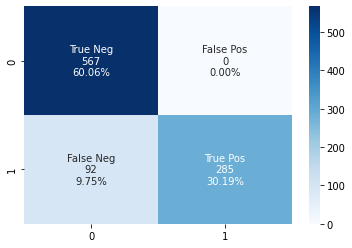

In [17]:
y_predict_knn = knn_model.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, y_predict_knn)
plot_confusion_matrix(knn_conf_matrix)

## SMV

In [18]:
# find best values of C and Gamma
c_values = [0.1, 1, 10, 100, 1000]
gamma_values = [0.001, 0.01, 0.1, 1]

param_grid = {'C': c_values, 'gamma': gamma_values}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# set C and Gamma values
c = grid_search.best_estimator_.C
gamma = grid_search.best_estimator_.gamma
print('Best C: ', c)
print('Best Gamma ', gamma)

svm_model = SVC(C=c, gamma=gamma, kernel='rbf',probability=True)
svm_model.fit(X_train, y_train)

Best C:  10
Best Gamma  0.1


SVC(C=10, gamma=0.1, probability=True)

In [19]:
print("Accuracy: ", knn_model.score(X_test, y_test))

Accuracy:  0.902542372881356


In [20]:
print("Training set score: {:.2f}".format(svm_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(svm_model.score(X_test, y_test)))

Training set score: 1.00 
Test set score: 0.99


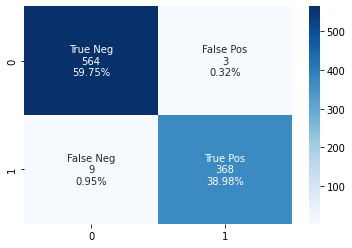

In [21]:
y_predict_svm = svm_model.predict(X_test)
svm_conf_matrix = confusion_matrix(y_test, y_predict_svm)
plot_confusion_matrix(svm_conf_matrix)

## Random Forest

In [22]:
# find best n_estimators and max_depth
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 9, 10]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid)
grid_search.fit(X_train, y_train)

# setting n_estimators and max_depth values
n_estimators = grid_search.best_estimator_.n_estimators
max_depth = grid_search.best_estimator_.max_depth

print('Best n_estimators:', n_estimators)
print('Best max_depth:', max_depth)

# training the model
forest_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
forest_model.fit(X_train, y_train)

Best n_estimators: 200
Best max_depth: 10


RandomForestClassifier(max_depth=10, n_estimators=200)

In [23]:
print("Accuracy: ", forest_model.score(X_test, y_test))

Accuracy:  0.9597457627118644


In [24]:
print("Training set score: {:.2f}".format(forest_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(forest_model.score(X_test, y_test)))

Training set score: 1.00 
Test set score: 0.96


In [25]:
y_predict_forest = forest_model.predict(X_test)
forest_conf_matrix = confusion_matrix(y_test, y_predict_forest)

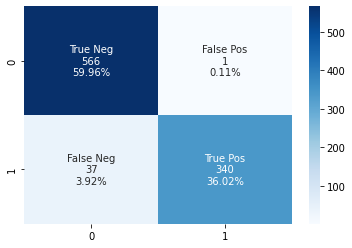

In [26]:
plot_confusion_matrix(forest_conf_matrix)

## Gradient Boosting

In [ ]:
# find best n_estimators, learning_rate and max_depth
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid)
grid_search.fit(X_train, y_train)

# setting the three parameters
n_estimators = grid_search.best_estimator_.n_estimators
learning_rate = grid_search.best_estimator_.learning_rate
max_depth = grid_search.best_estimator_.max_depth

print('Best n_estimators:', n_estimators)
print('Best learning_rate:', learning_rate)
print('Best max_depth:', max_depth)

grad_boost_model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
grad_boost_model.fit(X_train, y_train)

In [ ]:
print("Accuracy: ", grad_boost_model.score(X_test, y_test))

In [ ]:
print("Training set score: {:.2f}".format(grad_boost_model.score(X_train, y_train)),
      "\nTest set score: {:.2f}".format(grad_boost_model.score(X_test, y_test)))

In [ ]:
y_predict_grad_boost = grad_boost_model.predict(X_test)
grad_boost_conf_matrix = confusion_matrix(y_test, y_predict_grad_boost)

In [ ]:
plot_confusion_matrix(grad_boost_conf_matrix)